In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras import layers, optimizers
from keras.preprocessing.image import ImageDataGenerator
from tf.keras.preprocessing import image_dataset_from_directory

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices('GPU')

ModuleNotFoundError: No module named 'tf.keras'; 'tf' is not a package

In [3]:
fig_shape = None #Valore che ricaviamo inseguito 
batch_size = 512

### Load and split the dataset into Training (80%) and Validation (20%) dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = 0.2,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'training',
    seed = 42,
)

validation = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    subset = 'validation',
    seed = 42,
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


### Load the Test dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
)

test = train_datagen.flow_from_directory(
    'fruits-360/Test',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
)

Found 22688 images belonging to 131 classes.


### Some fruits exaple

In [5]:
train

# Convolutional Neural Network

In [24]:
model = Sequential()
model.add(layers.Input(shape = (100,100,3)))

model.add(layers.Conv2D(8 , 3, activation = 'swish'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8 , 3, activation = 'swish'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Conv2D(8 , 3, activation = 'swish'))
model.add(layers.MaxPooling2D(2))

model.add(layers.Flatten())
model.add(layers.Dense(131, activation = "softmax"))

model.compile(optimizer = optimizers.RMSprop(learning_rate=0.0001), loss = tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 8)         224       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 8)         584       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 8)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 8)         584       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 10, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)              

In [25]:
history = model.fit(
    train,
    batch_size = batch_size,
    epochs = 20,
    validation_data = validation,
    steps_per_epoch = len(train),
    validation_steps = len(validation)
)

Epoch 1/20
106/106 [==============================] - 24s 224ms/step - loss: 4.7945 - accuracy: 0.0157 - val_loss: 4.6718 - val_accuracy: 0.0168
Epoch 2/20
106/106 [==============================] - 24s 223ms/step - loss: 4.3098 - accuracy: 0.0782 - val_loss: 3.9009 - val_accuracy: 0.1115
Epoch 3/20
106/106 [==============================] - 24s 223ms/step - loss: 3.2464 - accuracy: 0.2410 - val_loss: 3.0322 - val_accuracy: 0.3115
Epoch 4/20
106/106 [==============================] - 23s 221ms/step - loss: 2.4060 - accuracy: 0.4137 - val_loss: 2.5109 - val_accuracy: 0.4085
Epoch 5/20
106/106 [==============================] - 24s 223ms/step - loss: 1.8948 - accuracy: 0.5313 - val_loss: 2.1022 - val_accuracy: 0.4862
Epoch 6/20
106/106 [==============================] - 24s 223ms/step - loss: 1.5136 - accuracy: 0.6149 - val_loss: 1.7840 - val_accuracy: 0.5607
Epoch 7/20
106/106 [==============================] - 24s 222ms/step - loss: 1.2159 - accuracy: 0.6892 - val_loss: 1.5714 - val_ac

### Visualize the loss function and the accuracy through the training

In [26]:
print('Informations stored in hystory:')
for key in history.history.keys():
    print(key)

Informations stored in hystory:
loss
accuracy
val_loss
val_accuracy


Text(0.5, 1.0, 'Loss')

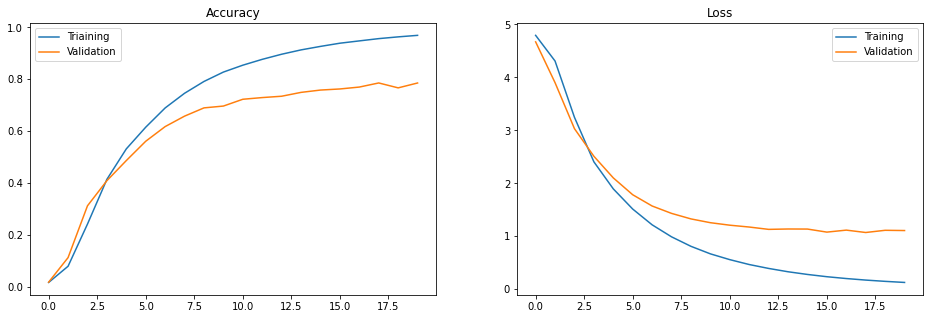

In [27]:
_ , ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(history.history['accuracy'], label = 'Triaining')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].legend()
ax[1].set_title('Loss')

### Evaluate the model on the Test Dataset

In [28]:
score = model.evaluate(test, batch_size = batch_size, steps = len(test))

45/45 [==============================] - 8s 172ms/step - loss: 1.3216 - accuracy: 0.7473


In [29]:
print('**********************************************')
print('* Acurracy of the model = %s *' %(score[1]))
print('**********************************************')

**********************************************
* Acurracy of the model = 0.7472673058509827 *
**********************************************


# PCA and Decision Tree

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split = 0.2,
)

train = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset = 'training',
    seed = 42,
)

validation = train_datagen.flow_from_directory(
    'fruits-360/Training',
    target_size=(100, 100),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset = 'validation',
    seed = 42,
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.


In [17]:
x=np.concatenate([train.next()[0] for i in range(35)])
y=np.concatenate([train.next()[1] for i in range(35)])
print(x.shape)
print(y.shape)

(17920, 100, 100, 3)
(17920, 131)


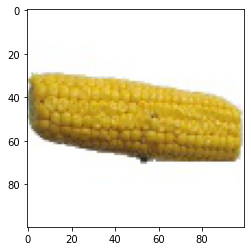

In [27]:
plt.imshow(x[1])